## 9up

ansel 之前提過的一個9買策略，隨便什麼時間進場，設 1% 止損 2%止盈，看最終結果。

In [1]:
from backtesting import Backtest, Strategy

import yfinance as yf
import pandas_ta as ta

import matplotlib.pyplot as plt

import random
import datetime

/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [28]:
df = yf.download("^SPX", period="60d", interval="5m")

[*********************100%%**********************]  1 of 1 completed


把時間改為 +8 時區，方便設置可交易時段

In [29]:
# df.set_index('Datetime', inplace=True)
df.index = df.index.tz_convert('Asia/Shanghai')

加一個 ATR

In [32]:
df['atr'] = ta.atr(df.High, df.Low, df.Close, length=14, fillna=0)

In [72]:
def testSt(st):
    bt = Backtest(
        df, 
    
        # Strategy
        st, 
    
        # Commission
        commission=.0001, 
    
        # default marketing on next day's open price, change to close price of current day
        trade_on_close=True,
    
        # 1 order each time
        exclusive_orders=True 
    )
    
    return bt, bt.run()

策略本體

In [84]:
class Up9(Strategy):
    def init(self):
        pass
        
    def next(self):
        price = self.data.Close[-1]
        
        if self.position:
            pass
        elif random.random() > 0.5:
            self.buy(size=1, sl=price * 0.99, tp=price * 1.02)

bt, stats = testSt(Up9)
stats

Start                     2023-12-04 22:30...
End                       2024-02-24 04:55...
Duration                     81 days 06:25:00
Exposure Time [%]                   99.771062
Equity Final [$]                 10523.804789
Equity Peak [$]                  10539.964945
Return [%]                           5.238048
Buy & Hold Return [%]               11.446859
Return (Ann.) [%]                   21.774359
Volatility (Ann.) [%]                5.389792
Sharpe Ratio                         4.039925
Sortino Ratio                        8.955706
Calmar Ratio                        18.057039
Max. Drawdown [%]                   -1.205865
Avg. Drawdown [%]                   -0.091887
Max. Drawdown Duration       13 days 22:45:00
Avg. Drawdown Duration        0 days 14:08:00
# Trades                                    9
Win Rate [%]                        77.777778
Best Trade [%]                       1.989801
Worst Trade [%]                     -1.009899
Avg. Trade [%]                    

這 60 天全在上升區間，只開了 9 單，win rate 77%, 收益 5.23%，比從一開始買了放著的 buy & hold 的 11% 少了一半以上

In [85]:
bt.plot()

/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:455: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig =

GridPlot(id='p1969', ...)

加上最多持有 12ts 和連續跌 3ts 平倉，選的 ts 是5分鐘，12ts 就是 1小時

In [86]:
class Up9_1(Strategy):
    def init(self):
        self.holding = 0
        self.cdd = 0
        
    def next(self):
        # Close price of previous day
        prev_price = self.data.Close[-2]
        price = self.data.Close[-1]
        
        if self.position:
            self.holding += 1

            # 持倉後連續跌
            if price < prev_price:
                self.cdd += 1
            else:
                self.cdd = 0

            # 最多持有 ts
            if self.holding > 12:
                self.position.close()

            # 連續跌 3 個 ts
            if self.cdd > 3:
                self.position.close()
        elif random.random() > 0.5:
            self.buy(size=1, sl=price * 0.99, tp=price * 1.02)
            self.holding = 0
            self.cdd = 0


bt, stats = testSt(Up9_1)
stats

Start                     2023-12-04 22:30...
End                       2024-02-24 04:55...
Duration                     81 days 06:25:00
Exposure Time [%]                   92.651099
Equity Final [$]                 10411.584288
Equity Peak [$]                  10425.061856
Return [%]                           4.115843
Buy & Hold Return [%]               11.446859
Return (Ann.) [%]                   16.828158
Volatility (Ann.) [%]                4.770511
Sharpe Ratio                         3.527538
Sortino Ratio                        7.825046
Calmar Ratio                         13.72204
Max. Drawdown [%]                    -1.22636
Avg. Drawdown [%]                   -0.106575
Max. Drawdown Duration       14 days 17:50:00
Avg. Drawdown Duration        0 days 17:19:00
# Trades                                  314
Win Rate [%]                        56.369427
Best Trade [%]                       1.989801
Worst Trade [%]                     -1.009899
Avg. Trade [%]                    

持有的時間邊短了，開單的機會就多，開了314 單，收益沒有變化，win rate 跌到 56%

如果只在晚上10點半到凌晨2點半之間開單，因為有過夜費，設置最長持有 ts

In [102]:
class Up9_2(Strategy):
    def init(self):
        self.holding = 0
        self.st = datetime.time(22, 30, 0)
        self.et = datetime.time(0, 30, 0)
        
    def next(self):
        price = self.data.Close[-1]

        rand = random.random() > 0.5

        # 只在指定時間段交易
        t = self.data.index[-1].time()
        in_time = t > self.st or t <= self.et
        
        if self.position:
            self.holding += 1
            if self.holding > 12:
                self.position.close()
        elif rand and in_time:
            self.buy(size=1, sl=price * 0.99, tp=price * 1.02)
            self.holding = 0
            self.cdd = 0


bt, stats = testSt(Up9_2)
stats

Start                     2023-12-04 22:30...
End                       2024-02-24 04:55...
Duration                     81 days 06:25:00
Exposure Time [%]                   35.897436
Equity Final [$]                 10031.594937
Equity Peak [$]                  10059.318827
Return [%]                           0.315949
Buy & Hold Return [%]               11.446859
Return (Ann.) [%]                    1.818756
Volatility (Ann.) [%]                2.175091
Sharpe Ratio                         0.836175
Sortino Ratio                        1.268679
Calmar Ratio                         2.444096
Max. Drawdown [%]                   -0.744143
Avg. Drawdown [%]                   -0.191338
Max. Drawdown Duration       35 days 00:55:00
Avg. Drawdown Duration        5 days 19:14:00
# Trades                                  112
Win Rate [%]                             50.0
Best Trade [%]                       0.583531
Worst Trade [%]                      -0.54908
Avg. Trade [%]                    

加上 ATR

In [114]:
class Up9_3(Strategy):
    def init(self):
        self.holding = 0
        self.st = datetime.time(22, 30, 0)
        self.et = datetime.time(0, 30, 0)
        
    def next(self):
        price = self.data.Close[-1]

        rand = random.random() > 0.5

        t = self.data.index[-1].time()
        in_time = t > self.st or t <= self.et

        in_atr = self.data['atr'][-1] > 3
        
        if self.position:
            self.holding += 1
            if self.holding > 12:
                self.position.close()
        elif rand and in_time and in_atr:
            self.buy(size=1, sl=price * 0.99, tp=price * 1.02)
            self.holding = 0
            self.cdd = 0


bt, stats = testSt(Up9_3)
stats

Start                     2023-12-04 22:30...
End                       2024-02-24 04:55...
Duration                     81 days 06:25:00
Exposure Time [%]                   30.769231
Equity Final [$]                 10050.030371
Equity Peak [$]                  10072.479261
Return [%]                           0.500304
Buy & Hold Return [%]               11.446859
Return (Ann.) [%]                    1.980927
Volatility (Ann.) [%]                2.055947
Sharpe Ratio                         0.963511
Sortino Ratio                        1.420252
Calmar Ratio                         2.871938
Max. Drawdown [%]                   -0.689753
Avg. Drawdown [%]                   -0.152941
Max. Drawdown Duration       35 days 00:20:00
Avg. Drawdown Duration        4 days 23:01:00
# Trades                                   96
Win Rate [%]                             50.0
Best Trade [%]                       0.538212
Worst Trade [%]                     -0.580287
Avg. Trade [%]                    

在 ATR 較高的區間開單，開單數多了一些，但收益並沒有增加

In [115]:
bt.plot()

/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:455: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig =

GridPlot(id='p2633', ...)

因為開單是用 rand 隨機，試了下多個樣本

In [116]:
%%time
rts = [testSt(Up9_3) for i in range(500)]

CPU times: user 46 s, sys: 166 ms, total: 46.2 s
Wall time: 46.2 s


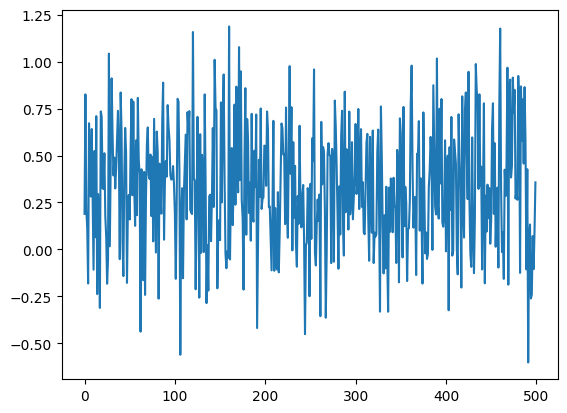

In [117]:
plt.plot([stats['Return [%]'] for (bt, stats) in rts])

這兩月裡的 spx 上升最猛的時間段都是跨兩日之間的 gap，所以將交易時間短限制在 10點半到12點半之間，1小時就平倉的話，基本沒什麼收益